In [39]:
import numpy as np
from numpy.typing import ArrayLike

dataset = "mushrooms.txt"
from lovely_numpy import lo
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from typing import List
from sklearn.model_selection import train_test_split


data = load_svmlight_file(dataset)
D, b = data[0].toarray(), data[1]
b = 2 * b - 3

D_train, D_val, b_train, b_val = train_test_split(D, b, test_size=0.25)

In [40]:
def quantize_vector(v: ArrayLike, K) -> ArrayLike:
    # randK quantization of the vector
    # K - number of nonzero vector elements after the quantization
    to_erase = len(v) - K
    rand_indeces = np.random.choice(len(v), size=to_erase, replace=False)
    v_q = v.copy()
    v_q[rand_indeces] = 0
    return v_q


def quantize_vector_robust(v: ArrayLike, ids) -> ArrayLike:
    v_q = v.copy()
    v_q[ids] = 0
    return v_q


def calculate_loss(DX: ArrayLike, b: ArrayLike) -> np.float32:
    # ||DX - b||_2^2
    return np.linalg.norm(DX - b) ** 2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def accuracy_score(D, X, b):
    vals = D @ X
    # preds = sigmoid(vals)
    preds = [-1 if val < 0 else 1 for val in vals]
    return np.sum(preds == b) / len(b)

In [41]:
class ClientServer:
    def __init__(self, d_i: ArrayLike, gamma=5e-4) -> None:
        self.d = d_i
        self.x = np.random.random()
        self.f = None
        self.gamma = gamma
        self.grad = None

    # calculate target function on the client feature
    # f_i = d_i * x_i
    def calculate_local_function(self) -> ArrayLike:
        f_i = self.d * self.x
        self.f = f_i
        return self.f

    def calculate_quantized_local_function(self, K) -> ArrayLike:
        f_i = self.d * self.x
        self.f = quantize_vector(f_i, K)

    def calculate_quantized_local_function_robust(self, ids) -> ArrayLike:
        self.f = self.d * self.x
        return quantize_vector_robust(self.f, ids)

    def loss_gradient(self, error_vector: ArrayLike) -> np.float32:
        # error vector = DX - b
        # dL/(dx_i) = 2d_i^T(DX - b)
        dL = 2 * self.d.T @ error_vector
        self.grad = dL

    
    def cumulative_loss_gradient(self, error_vector_dif):
        # error_vector = Q(D(X^{k+1} - X^{k}))
        # dL/(dx_i) = dL/(dx_i) + 2d_i^T * error_vector
        dL = 2 * self.d.T @ error_vector_dif
        self.grad += dL

    def gradient_step(self):
        # x^{k+1} = x - 2gamma*d_i^T(DX - b)
        # error_vector = DX - b
        self.x = self.x - self.gamma * self.grad

In [42]:
# Calculating DX = sum(d_i * x_i) for all clients
def client_values_aggregation(clients: List) -> ArrayLike:
    # dx_values - vector of dx values from all clients (matrix)
    # return - aggregation of all dx values (sum)
    dx_values = np.array(list(map(lambda x: x.f, clients)))
    return np.sum(dx_values, axis=0)  # DX


# collect x_i from all clients
def construct_full_vector(clients: List[ClientServer]):
    X = []
    for client in clients:
        X.append(client.x)
    return np.array(X)

In [43]:
Hessian = 2 * D.T @ D
L = np.max(np.linalg.eigvalsh(Hessian))

In [44]:
def gradient_step(
    clients: List[ClientServer],  # list of clients, to train
    D,  # full version of the Dataset
    b,  # vector of true labels
    K,  # number of features to leave after the Quantization
    single_rseed=True,  # uage of the single random seed to have zeros on the same ids
    cum_grad=False,  # cumulative gradient for the marina-like gradient calculation
    prev_error_vector=None,  # previous error-vector for the cumulative gradient
):
    erase_ids = np.random.choice(D.shape[0], size=D.shape[0] - K, replace=False)
    local_function_values = []
    for client in clients:
        if cum_grad:
            if not single_rseed:
                erase_ids = np.random.choice(
                    D.shape[0], size=D.shape[0] - K, replace=False
                )
            f_i = client.calculate_quantized_local_function_robust(erase_ids)
            # f_i = client.calculate_local_function()
        else:
            f_i = client.calculate_local_function()

        local_function_values.append(f_i)

    DX = np.sum(local_function_values, axis=0)
    if not single_rseed:
        erase_ids = np.random.choice(D.shape[0], size=D.shape[0] - K, replace=False)

    error_vector = DX - b
    if cum_grad:
        error_vector_dif = error_vector - prev_error_vector
        error_vector_dif = quantize_vector_robust(error_vector_dif, erase_ids)
    grad_norm = 0
    for client in clients:
        if cum_grad:
            client.cumulative_loss_gradient(error_vector_dif)
        else:
            client.loss_gradient(error_vector)

        grad_norm += np.abs(client.grad)
        client.gradient_step()
        client.calculate_local_function()
    return grad_norm, error_vector

In [45]:
def run_experiment(num_iters, K, D, b, single_rseed=True, g=1.5/L, p=0.1):
    feature_clients = []
    for feature in D.T:
        client = ClientServer(feature, gamma=g)
        client.calculate_local_function()
        feature_clients.append(client)

    iters = range(num_iters)
    loss_hist = []
    grad_hist = []
    progress = tqdm(iters)
    prev_error_vector = None
    for i in progress:
        rand_num = np.random.random()
        ck = 1 if rand_num <= p else 0
        if i == 0:
            ck = 1  # in the first step calculate full gradient

        grad_norm, prev_error_vector = gradient_step(
            feature_clients,
            D,
            b,
            K,
            single_rseed,
            cum_grad=not ck,
            prev_error_vector=prev_error_vector,
        )
        if i == 0:
            init_gradnorm = grad_norm

        X = construct_full_vector(feature_clients)
        loss = np.linalg.norm(D @ X - b) ** 2
        progress.set_description(
            f"Loss: {loss:.3e}, Grad Norm: {grad_norm / init_gradnorm:.3e}"
        )
        loss_hist.append(loss)
        grad_hist.append(grad_norm / init_gradnorm)

    X = construct_full_vector(feature_clients)
    acc_train = accuracy_score(D, X, b)
    print(acc_train)
    return loss_hist, grad_hist, X

$$
\gamma = \frac{1}{L} \times \frac{k}{\| D \|}
$$

$$
p = \left( 1 - \frac{k}{\| D \|} \right)^2
$$

Loss: 3.300e+05, Grad Norm: 7.927e-01:   1%|          | 11/1000 [00:00<00:09, 109.35it/s]

Loss: 4.882e+03, Grad Norm: 1.719e-02: 100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


0.8023961923518792
Accuracy on train set With K = 100: 0.802
Accuracy on val set With K = 100: 0.7951747907434761


Loss: 1.549e+03, Grad Norm: 3.979e-03: 100%|██████████| 1000/1000 [00:16<00:00, 61.79it/s]


0.9525685212538979
Accuracy on train set With K = 1000: 0.953
Accuracy on val set With K = 1000: 0.9507631708517972


Loss: 8.565e+02, Grad Norm: 4.199e-03: 100%|██████████| 1000/1000 [00:20<00:00, 49.64it/s]


0.9688166748728049
Accuracy on train set With K = 2000: 0.969
Accuracy on val set With K = 2000: 0.9630723781388478


Loss: 2.045e+02, Grad Norm: 5.307e-04: 100%|██████████| 1000/1000 [00:32<00:00, 31.09it/s]


0.9962251764319711
Accuracy on train set without Quantization: 0.996
Accuracy on val set  without Quantization: 0.9950763170851797


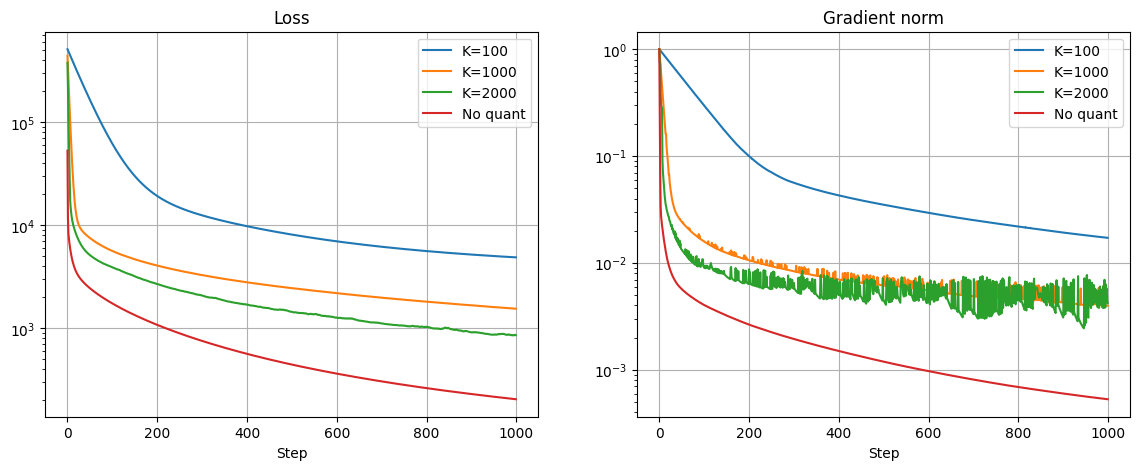

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel("Step")
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel("Step")

Ks = [100, 1000, 2000, D_train.shape[0]]
# Ks = [D_train.shape[0]]
for k in Ks:
    q = True
    if k == D_train.shape[0]:
        q = False
    
    cur_gamma = 1/L / (D_train.shape[0] / k)
    cur_p = (1 - k / D_train.shape[0])
    
    loss_history, grad_norm_history, X = run_experiment(
        1000, k, D_train, b_train, single_rseed=False, g=cur_gamma, p=cur_p
    )
    label = f"K={k}"
    if not q:
        label = "No quant"
    axes[0].plot(loss_history, label=label)
    axes[1].plot(grad_norm_history, label=label)
    acc_train = accuracy_score(D_train, X, b_train)
    acc_val = accuracy_score(D_val, X, b_val)
    if k != D_train.shape[0]:
        print(f"Accuracy on train set With K = {k}: {acc_train:.3f}")
        print(f"Accuracy on val set With K = {k}: {acc_val}")
    else:
        print(f"Accuracy on train set without Quantization: {acc_train:.3f}")
        print(f"Accuracy on val set  without Quantization: {acc_val}")
    print("=" * 75)

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[0].legend()
axes[1].legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 5.002e+03, Grad Norm: 1.454e-02: 100%|██████████| 1000/1000 [00:13<00:00, 73.21it/s]


0.8048580338092893
Accuracy on train set With K = 100: 0.805
Accuracy on val set With K = 100: 0.7882816346627277


Loss: 1.097e+03, Grad Norm: 3.123e-03: 100%|██████████| 1000/1000 [00:13<00:00, 76.38it/s]


0.9609387822090923
Accuracy on train set With K = 1000: 0.961
Accuracy on val set With K = 1000: 0.9517479074347612


Loss: 6.926e+02, Grad Norm: 1.802e-03: 100%|██████████| 1000/1000 [00:14<00:00, 66.89it/s]


0.9814541276875103
Accuracy on train set With K = 2000: 0.981
Accuracy on val set With K = 2000: 0.9758739537173806


Loss: 2.196e+02, Grad Norm: 5.542e-04: 100%|██████████| 1000/1000 [00:16<00:00, 61.29it/s]


0.995732808140489
Accuracy on train set without Quantization: 0.996
Accuracy on val set  without Quantization: 0.9955686853766618


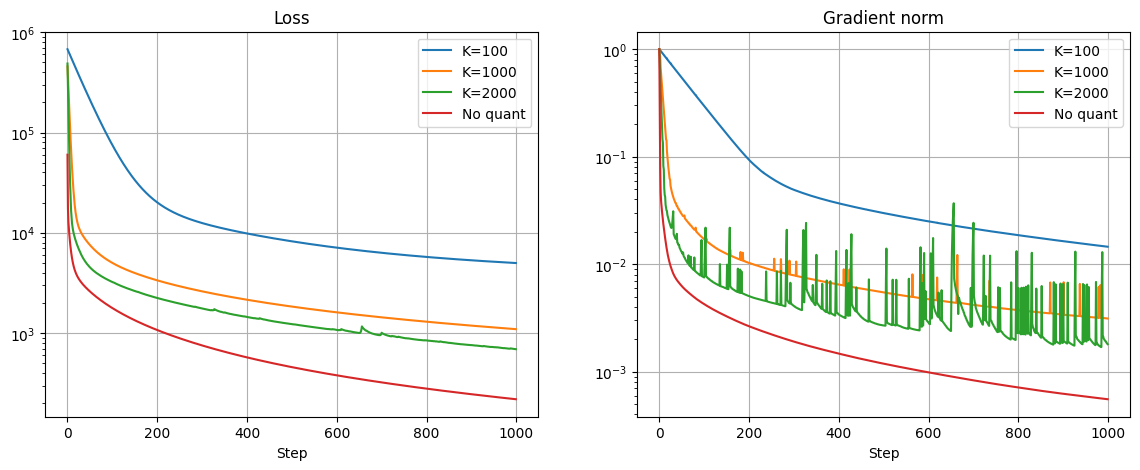

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].grid()
axes[0].set_title("Loss")
axes[0].set_xlabel("Step")
axes[1].grid()
axes[1].set_title("Gradient norm")
axes[1].set_xlabel("Step")

Ks = [100, 1000, 2000, D_train.shape[0]]
# Ks = [D_train.shape[0]]
for k in Ks:
    q = True
    if k == D_train.shape[0]:
        q = False
    
    cur_gamma = 1/L / (D_train.shape[0] / k)
    cur_p = (1 - k / D_train.shape[0])
    
    loss_history, grad_norm_history, X = run_experiment(
        1000, k, D_train, b_train, single_rseed=True, g=cur_gamma, p=cur_p
    )
    label = f"K={k}"
    if not q:
        label = "No quant"
    axes[0].plot(loss_history, label=label)
    axes[1].plot(grad_norm_history, label=label)
    acc_train = accuracy_score(D_train, X, b_train)
    acc_val = accuracy_score(D_val, X, b_val)
    if k != D_train.shape[0]:
        print(f"Accuracy on train set With K = {k}: {acc_train:.3f}")
        print(f"Accuracy on val set With K = {k}: {acc_val}")
    else:
        print(f"Accuracy on train set without Quantization: {acc_train:.3f}")
        print(f"Accuracy on val set  without Quantization: {acc_val}")
    print("=" * 75)

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[0].legend()
axes[1].legend()
plt.show()